# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **sports or athletics** (see below) for the region of **Ann Arbor, Michigan, United States**, or **United States** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **Ann Arbor, Michigan, United States** to Ann Arbor, USA. In that case at least one source file must be about **Ann Arbor, Michigan, United States**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **Ann Arbor, Michigan, United States** and **sports or athletics**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **sports or athletics**?  For this category we are interested in sporting events or athletics broadly, please feel free to creatively interpret the category when building your research question!

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

# 1. Region and Domain

Ann Arbor, MI

sports or athletics

# 2. Research Question

How are the scores and win rates of the University of Michigan Wolverines football team affected by the weather on the day of the game?

# 3. Links to Datasets

* [Michigan Wolverines Football data archive](http://statsarchive.ath.umich.edu/VS-Football/footstart.php) - I gathered this data "manually". I.e. I entered each year into the form on the linked page, copied out the table of data, and pasted that into a file `{year}-wolverines.txt`. Those files accompany this notebook.
* Need to convert each City, State pair into a Lat, Long. For this I used the [Google Maps Geocoding API](https://developers.google.com/maps/documentation/geocoding/intro). Code is below.
* Historical weather data from [Dark Sky](https://darksky.net/poweredby/). I gathered this through their API. Code is below.

# 4. Image

Let's make it, shall we?

First we read and clean all the game data I collected.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cols = ["Opponent", "Date", "Location", "Result and Scores"]

all_season_dfs = []
for year in range(1949, 2018):
    # Read data from file
    with open("data/{}-wolverines.txt".format(year)) as f:
        data = [line.strip().split("\t") for line in f.readlines()]
    
    # Create dataframe
    df = pd.DataFrame(data, columns=cols)
    
    # Some locations are empty. We need that for our analysis, so just drop those games.
    df = df[(df['Location'] != '') & (~df['Location'].isna())]
    
    # Keep track of the season, as some games happen in the next calendar year.
    df["Season"] = year
    
    all_season_dfs.append(df)

In [2]:
# Build dataframe from individual season dataframes
games_df = pd.concat(all_season_dfs, ignore_index=True)

# Clean up locations
location_name_replacements = {
    "Ann arbor, MI": "Ann Arbor, MI",
    "Arlington, Texas": "Arlington, TX",
    "Bloomington, Ind.": "Bloomington, IN",
    "Champaign, Ill.": "Champaign, IL",
    "College Park, Md.": "College Park, MD",
    "Columbus, Ohio": "Columbus, OH",
    "East Hartford, Conn.": "East Hartford, CT",
    "East Lansing, Mich.": "East Lansing, MI",
    "East Lansing,MI": "East Lansing, MI",
    "Eugene, Ore.": "Eugene, OR",
    "Evanston, Il.": "Evanston, IL",
    "Evanston, Ill.": "Evanston, IL",
    "Evanston,Il": "Evanston, IL",
    "Iowa City, Iowa": "Iowa City, IA",
    "Lincoln, Neb.": "Lincoln, NE",
    "Madison, Wisconsin": "Madison, WI",
    "Madison, Wis": "Madison, WI",
    "Miami Gardens, Fla.": "Miami Gardens, FL",
    "Minneapolis": "Minneapolis, MN",
    "Minneapolis, Minn.": "Minneapolis, MN",
    "New Orleans, La.": "New Orleans, LA",
    "Notre Dame, Ind.": "Notre Dame, IN",
    "Orlando, Fla.": "Orlando, FL",
    "Pasadena, Calif.": "Pasadena, CA",
    "Piscataway, N.J.": "Piscataway, NJ",
    "Salt Lake City, Utah": "Salt Lake City, UT",
    "Seattle, Wash.": "Seattle, WA",
    "South Bend, Ind.": "South Bend, IN",
    "State College, Pa.": "State College, PA",
    "Tampa, Fla.": "Tampa, FL",
    "Tempe, Ariz": "Tempe, AZ",
    "University Park, Pa.": "University Park, PA",
    "West Lafayette, Ind.": "West Lafayette, IN"
}
games_df.replace({"Location": location_name_replacements}, inplace=True)

# Make Date column a datetime
games_df['Date'] = games_df['Date'].apply(pd.to_datetime)

# Assume the games happened at noon
noon_shift = pd.Timedelta('12 hours')
games_df['Date'] = games_df['Date'].apply(lambda x: x + noon_shift)

# Split up the 'Result and Scores' column
games_df['Result'] = games_df['Result and Scores'].apply(lambda x: x.split(" ")[0])
games_df['Win'] = games_df['Result'].apply(lambda x: 1 if x == 'W' else 0)
games_df['Loss'] = games_df['Result'].apply(lambda x: 1 if x == 'L' else 0)
games_df['Wolverine Points'] = games_df['Result and Scores'].apply(lambda x: int(x.split(" ")[1].split("-")[0]))
games_df['Opponent Points'] = games_df['Result and Scores'].apply(lambda x: int(x.split(" ")[1].split("-")[1]))
games_df['Point Differential'] = games_df['Wolverine Points'] - games_df['Opponent Points']

games_df.head()

,Opponent,Date,Location,Result and Scores,Season,Result,Win,Loss,Wolverine Points,Opponent Points,Point Differential
0,Michigan State,1949-09-24 12:00:00,"Ann Arbor, MI",W 7-3,1949,W,1,0,7,3,4
1,Stanford,1949-10-01 12:00:00,"Stanford, CA",W 27-7,1949,W,1,0,27,7,20
2,Army,1949-10-08 12:00:00,"Ann Arbor, MI",L 7-21,1949,L,0,1,7,21,-14
3,Northwestern,1949-10-15 12:00:00,"Evanston, IL",L 20-21,1949,L,0,1,20,21,-1
4,Minnesota,1949-10-22 12:00:00,"Ann Arbor, MI",W 14-7,1949,W,1,0,14,7,7


Next we use Google's Geocoding API to turn the City, State locations into latitude and longitude. This is necessary to use Dark Sky's weather API.

In [3]:
# Get Lat and Long for city
import googlemaps

google_maps_key = "my google api key"
gmaps = googlemaps.Client(key=google_maps_key)

geocodes = {loc: gmaps.geocode(loc) for loc in games_df["Location"].unique()}

In [4]:
# Pull out Lat/Long data from geocode API result and put it into dataframe
lats = {loc: gc[0]['geometry']['location']['lat'] for loc, gc in geocodes.items()}
longs = {loc: gc[0]['geometry']['location']['lng'] for loc, gc in geocodes.items()}

games_df['Latitude'] = games_df['Location'].replace(lats)
games_df['Longitude'] = games_df['Location'].replace(longs)
games_df.head()

,Opponent,Date,Location,Result and Scores,Season,Result,Win,Loss,Wolverine Points,Opponent Points,Point Differential,Latitude,Longitude
0,Michigan State,1949-09-24 12:00:00,"Ann Arbor, MI",W 7-3,1949,W,1,0,7,3,4,42.280826,-83.743038
1,Stanford,1949-10-01 12:00:00,"Stanford, CA",W 27-7,1949,W,1,0,27,7,20,37.424106,-122.166076
2,Army,1949-10-08 12:00:00,"Ann Arbor, MI",L 7-21,1949,L,0,1,7,21,-14,42.280826,-83.743038
3,Northwestern,1949-10-15 12:00:00,"Evanston, IL",L 20-21,1949,L,0,1,20,21,-1,42.045072,-87.687697
4,Minnesota,1949-10-22 12:00:00,"Ann Arbor, MI",W 14-7,1949,W,1,0,14,7,7,42.280826,-83.743038


Now use the lat, long location data and the date (with assumed time of 12 PM) with Dark Sky's API to get the weather data.

In [5]:
# Get weather data
# For this I use the Dark Sky API. You can get an API key for free by signing up on their website.
# There are python libraries for this API, but I think I'll skip them and use the API directly.

import requests

dark_sky_key = "my dark sky api key"
weather_url = "https://api.darksky.net/forecast/{key}/{lat},{long},{time}"

current_weather = []
for lat, long, time in games_df[['Latitude', 'Longitude', 'Date']].apply(lambda x: (x['Latitude'], x['Longitude'], x['Date'].strftime("%Y-%m-%dT%H:%M:%S")), axis=1):
    r = requests.get(weather_url.format(key=dark_sky_key, lat=lat, long=long, time=time),
                    params={"exclude": "hourly,flags,daily"})
    r.raise_for_status()
    current_weather.append(r.json()['currently'])


In [6]:
weather_df = pd.DataFrame(current_weather)

weather_cols = [
    'apparentTemperature',
    'cloudCover',
    'precipIntensity',
    'precipIntensityError',
    'precipProbability',
    'precipProbabilityError',
    'precipType',
    'windGust',
    'windSpeed',
    'windSpeedError'
]
combined_df = pd.concat((games_df, weather_df[weather_cols].fillna(0)), axis=1)
combined_df.head()

,Opponent,Date,Location,Result and Scores,Season,Result,Win,Loss,Wolverine Points,Opponent Points,...,apparentTemperature,cloudCover,precipIntensity,precipIntensityError,precipProbability,precipProbabilityError,precipType,windGust,windSpeed,windSpeedError
0,Michigan State,1949-09-24 12:00:00,"Ann Arbor, MI",W 7-3,1949,W,1,0,7,3,...,55.94,0.75,0.0058,0.1196,0.18,0.29,rain,0.0,13.88,0.0
1,Stanford,1949-10-01 12:00:00,"Stanford, CA",W 27-7,1949,W,1,0,27,7,...,78.75,0.00,0.0000,0.0000,0.00,0.00,0,0.0,1.26,0.0
2,Army,1949-10-08 12:00:00,"Ann Arbor, MI",L 7-21,1949,L,0,1,7,21,...,82.43,0.00,0.0052,0.1168,0.19,0.31,rain,0.0,11.63,0.0
3,Northwestern,1949-10-15 12:00:00,"Evanston, IL",L 20-21,1949,L,0,1,20,21,...,59.76,0.09,0.0000,0.0000,0.00,0.00,0,0.0,7.26,0.0
4,Minnesota,1949-10-22 12:00:00,"Ann Arbor, MI",W 14-7,1949,W,1,0,14,7,...,42.53,0.25,0.0046,0.1129,0.20,0.33,rain,0.0,26.40,0.0


## Data Exploration

We've gathered data on all the games and the weather at the time and place of the games. Can we find any relationship between them?

Let's poke around and see.

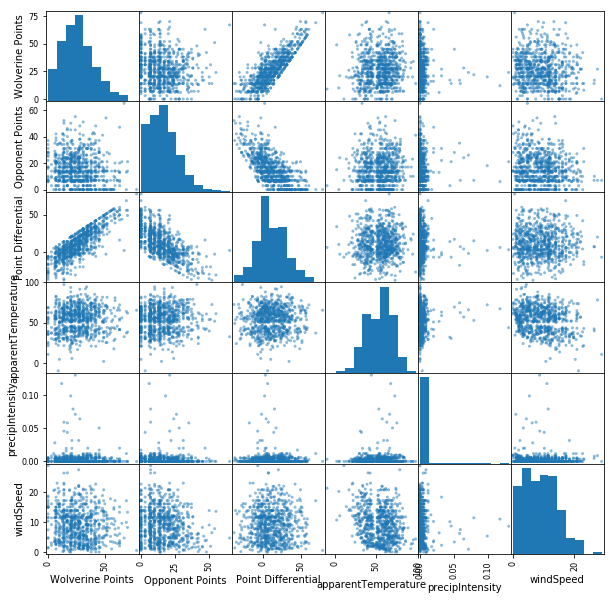

In [7]:
cols = ['Wolverine Points', 'Opponent Points', 'Point Differential', 'apparentTemperature', 'precipIntensity', 'windSpeed']
# home = combined_df['Location'] == 'Ann Arbor, MI'
# pd.plotting.scatter_matrix(combined_df.loc[home, cols], figsize=[10,10]);
# pd.plotting.scatter_matrix(combined_df.loc[~home, cols], figsize=[10,10]);
pd.plotting.scatter_matrix(combined_df[cols], figsize=[10,10]);

We want to focus on those cells where we have comparisons between the game outcomes (`Wolverine Points`, `Opponent Points`, and `Point Differential`) and the weather phenomena (`apparentTemperature`, `precipIntensity`, and `windSpeed`). A lot of these look like nothing to me. But one looks like it might have an interesting relationship. 

Let's zoom in a bit on `precipIntensity` vs `Point Differential`.

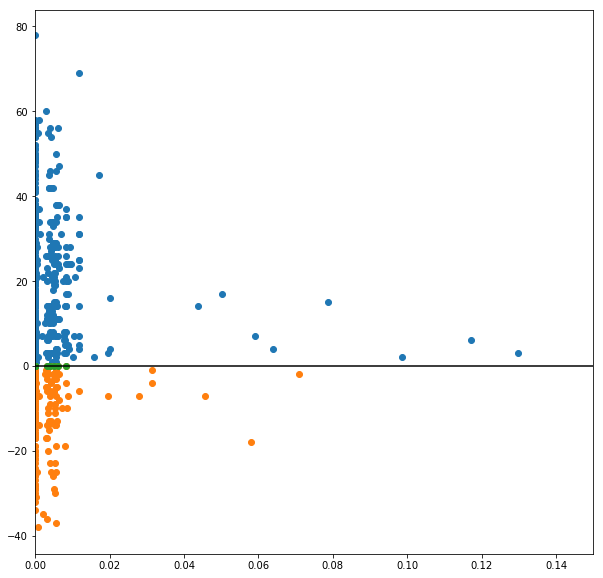

In [8]:
plt.figure(figsize=[10, 10])
ax = plt.gca()
ax.set_xlim([0, .15])
ax.scatter(combined_df.loc[combined_df['Point Differential'] > 0, 'precipIntensity'], combined_df.loc[combined_df['Point Differential'] > 0, 'Point Differential']);
ax.scatter(combined_df.loc[combined_df['Point Differential'] <= 0, 'precipIntensity'], combined_df.loc[combined_df['Point Differential'] <= 0, 'Point Differential']);
ax.scatter(combined_df.loc[combined_df['Point Differential'] == 0, 'precipIntensity'], combined_df.loc[combined_df['Point Differential'] == 0, 'Point Differential']);
ax.plot([0, .15], [0, 0], '-k');

That sure looks to me like they're more likely to win than lose when there is precipitation, and that likelihood goes up as the precipitation is more intense.

Let's try to make a plot of win percentage vs precipitation intensity. This is a little tricky because precipiation intensity is continuous. So what wins and losses—for what precipitation intensity values—are we comparing?

My initial approach was to bin the precipitation intensities and calculate the win rate per bin.

,Wins,Losses,Win %
Precip Intensity Bin,,,
"(-0.01, 0.0]",338.0,151.0,0.691207
"(0.0, 0.01]",170.0,68.0,0.714286
"(0.01, 0.019999999999999997]",17.0,2.0,0.894737
"(0.019999999999999997, 0.03]",2.0,1.0,0.666667
"(0.03, 0.04]",0.0,2.0,0.000000
"(0.04, 0.049999999999999996]",1.0,1.0,0.500000
"(0.049999999999999996, 0.060000000000000005]",2.0,1.0,0.666667
"(0.060000000000000005, 0.07]",1.0,0.0,1.000000
"(0.07, 0.08]",1.0,1.0,0.500000


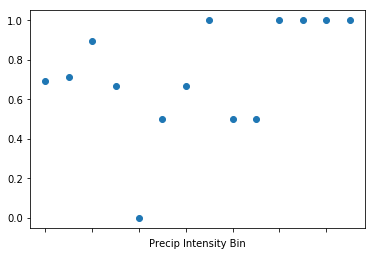

In [9]:
# Approach 1: Bin precip intensity

# Make column along which we will use groupby
bins = pd.interval_range(start=-0.01, end=0.13, periods=14)
combined_df['Precip Intensity Bin'] = pd.cut(combined_df['precipIntensity'], bins)

def Wins(s):
    return s[s == 'W'].count()

def Losses(s):
    return s[s == 'L'].count()

# Now we make a new data frame, grouped by the precipitation bin, with columns for number of wins and losses
win_loss_precip_df = combined_df[['Precip Intensity Bin', 'Result']].groupby('Precip Intensity Bin').agg([Wins, Losses])['Result']

# Add a win percent column
win_loss_precip_df['Win %'] = win_loss_precip_df['Wins'].div(win_loss_precip_df['Wins'] + win_loss_precip_df['Losses']).fillna(method='ffill')
win_loss_precip_df['Win %'].plot(style='o');
win_loss_precip_df

This is... well, I'm not entirely sure what it is. It seems to make the point I was going for, that as `precipIntensity` goes up, the win rate goes up. And for high levels of `precipIntensity`, the win rate is `100%`. 

But what this is missing is an error analysis. If I were to calculate and plot error bars for these points, the two or three on the left would have fairly low error—because they are calulated from lots of data—but the points on the right would have error bars filling the entire plot. They are based on one, or even zero, measurements. Not exactly confidence-inspiring.

I think I will take a different approach, which I hope will be better. I will cumulatively sum the wins and losses, and calculate a cumulative win percent. I will plot that, along with a linear regression. I can also plot the `p` value for the hypothesis that win percentage increases with increasing precipitation (against the null hypothesis of no relationship).

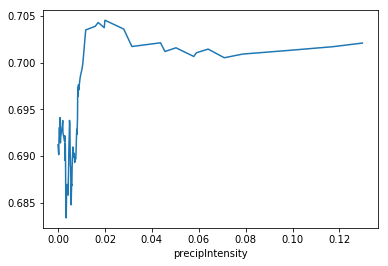

In [10]:
# Approach 2: Forget the bins. 
# Get cumulative win/loss values by precipIntensity and calculate cumulative win % from that.
precip_cum_df = combined_df[['precipIntensity', 'Win', 'Loss']].groupby('precipIntensity').agg(pd.Series.sum).cumsum()
precip_cum_df['Cumulative Win %'] = precip_cum_df['Win'].div(precip_cum_df['Win'] + precip_cum_df['Loss'])

# win_pct = precip_win_df['Cumulative Win %']

precip_cum_df['Cumulative Win %'].plot();

0.6932587647814503

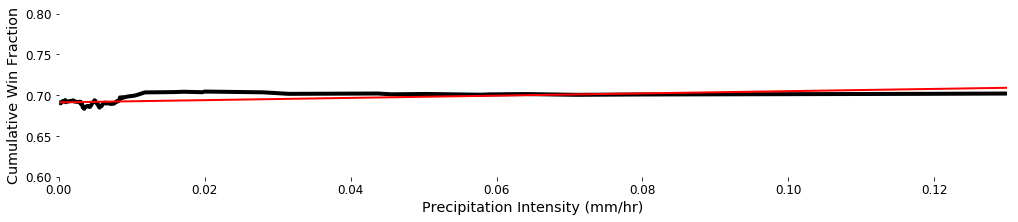

In [11]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(precip_cum_df.index, precip_cum_df['Cumulative Win %'])
x = np.array((0, 0.13))
fit = x*slope + intercept
# upper_confidence_interval = x*slope + intercept*(1 + p_value)
# lower_confidence_interval = x*slope + intercept*(1 - p_value)

fig = plt.figure(figsize=[17, 3])
ax = plt.gca()

# Plot precip vs win% data
ax.plot(precip_cum_df.index, precip_cum_df['Cumulative Win %'], color='k', linewidth=4);

# Plot linear regression
ax.plot(x, fit, color='r', linewidth=2);

# Plot 95% confidence interval
# ax.plot(x, upper_confidence_interval, color='r')
# ax.plot(x, lower_confidence_interval, color='r')
# ax.fill_between(x, upper_confidence_interval, lower_confidence_interval, color='r', alpha=0.3)

# Set limits
ax.set_xlim(x);
ax.set_ylim([0.6, 0.8]);

# Style
ax.set_ylabel('Cumulative Win Fraction', fontsize='x-large')
plt.yticks(fontsize='large')

ax.set_xlabel("Precipitation Intensity (mm/hr)", fontsize='x-large')
# xticks = plt.xticks()
plt.xticks(fontsize='large')

# Remove bounding box
for spine in ax.spines.values():
    spine.set_visible(False)

# ax.set_title("Wolverines Football Cumulative Win Fraction")
precip_cum_df['Cumulative Win %'].mean()

This is just not very good. My first plot was of `Point Differential`. Why did I ever switch to `Win %`? 

Let's go back to the `Point Differential` plot and try to make something out of that.

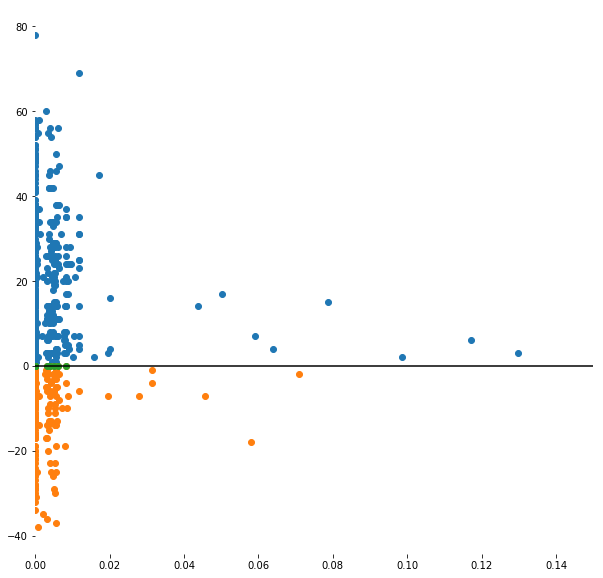

In [12]:
plt.figure(figsize=[10, 10])
ax = plt.gca()

ax.set_xlim([0, .15])

# Plot raw point differentials
ax.scatter(combined_df.loc[combined_df['Point Differential'] > 0, 'precipIntensity'], combined_df.loc[combined_df['Point Differential'] > 0, 'Point Differential']);
ax.scatter(combined_df.loc[combined_df['Point Differential'] <= 0, 'precipIntensity'], combined_df.loc[combined_df['Point Differential'] <= 0, 'Point Differential']);
ax.scatter(combined_df.loc[combined_df['Point Differential'] == 0, 'precipIntensity'], combined_df.loc[combined_df['Point Differential'] == 0, 'Point Differential']);
ax.plot([0, .15], [0, 0], '-k');

# Remove bounding box
for spine in ax.spines.values():
    spine.set_visible(False)

Let us calculate the "Expanding Mean" of these point differential data. We do this by, first, finding for each value of `precipIntensity` both the number of points and the sum of the point differentials at those points. We then *cumulatively* sum those values. Dividing the cumulative sum of point differentials by the cumulative count, we find an "expanding mean": the mean of all points with `precipIntensity` less than or equal to this one.

In [13]:
pointdiff_cum_df = combined_df[['precipIntensity', 'Point Differential']].groupby('precipIntensity').agg([pd.Series.sum, pd.Series.count])['Point Differential']
pointdiff_cum_df['cumulative sum'] = pointdiff_cum_df['sum'].cumsum()
pointdiff_cum_df['cumulative count'] = pointdiff_cum_df['count'].cumsum()
# pointdiff_cum_df['Per Precip Mean'] = pointdiff_cum_df['sum'].div(pointdiff_cum_df['count'])
pointdiff_cum_df['Expanding Mean'] = pointdiff_cum_df['cumulative sum'].div(pointdiff_cum_df['cumulative count'])

The reason to find the expanding mean is this: if we fit a line to it, we can tell by the slope of that line whether the points at high precipitation have a meaningful impact on the value of the mean. If the slope is positive or negative, than the mean has been changed from the value it had with only the low-precipitation points. If the slope is zero, the high-precipitation points have no impact.

The function `scipy.stats.linregress` will tell us the parameters of the line, `slope` and `intercept`, but also the `p` value for the hypothesis that the slope is non-zero. If the `p` value is low, we can be confident in rejecting the null hypothesis, which is that the slope is zero and there is no relationship. If the `p` value is high, we cannot reject that null hypothesis.

In [14]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(pointdiff_cum_df.index, pointdiff_cum_df['Expanding Mean'])
print("slope:{}\nintercept:{}\nr_value:{}\np_value:{}\nstd_err:{}".format(slope, intercept, r_value, p_value, std_err))

slope:0.3839768446290121
intercept:10.965936336902548
r_value:0.0569983273656367
p_value:0.5915097202881454
std_err:0.7129208271747964


That is quite a large `p` value! Looks like we cannot reject the null hypothesis that the slope is zero and there is no relationship between the variables.

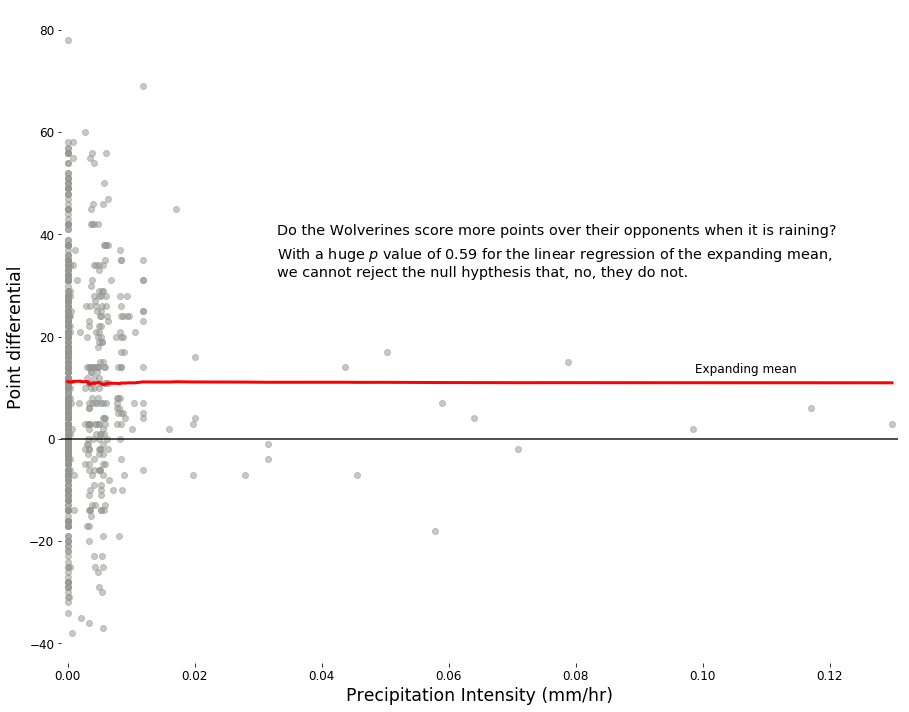

In [15]:
# Make figure
fig = plt.figure(figsize=[15,12])
ax = plt.gca()
xlim = [pointdiff_cum_df.index.min()-0.001, pointdiff_cum_df.index.max()+0.001]
ax.set_xlim(xlim)

ylim = plt.ylim

ax.set_ylabel("Point differential", fontsize="xx-large")
plt.yticks(fontsize='large')
ax.set_xlabel("Precipitation Intensity (mm/hr)", fontsize='xx-large')
plt.xticks(fontsize='large')

# Raw point differentials
ax.scatter(combined_df['precipIntensity'], combined_df['Point Differential'], color='xkcd:gray', alpha=0.5, label='_exclude from legend');

# Zero line, different between winning and losing
ax.plot(xlim, [0, 0], '-k', alpha=0.9);

# Expanding mean
ax.plot(pointdiff_cum_df.index, pointdiff_cum_df['Expanding Mean'], '-r', linewidth=3, label="Expanding Mean");

ax.text(0.75*(xlim[1]-xlim[0]), 13, "Expanding mean", fontsize='large')

ax.text(0.25*(xlim[1]-xlim[0]), 40, "Do the Wolverines score more points over their opponents when it is raining?", fontsize="x-large")
ax.text(0.25*(xlim[1]-xlim[0]), 32, "With a huge $p$ value of ${:.2f}$ for the linear regression of the expanding mean,\nwe cannot reject the null hypthesis that, no, they do not.".format(p_value), fontsize="x-large")

# Remove bounding box
for spine in ax.spines.values():
    spine.set_visible(False)